In [1]:
#pip install numpy pandas tensorflow matplotlib scikit-learn yfinance

In [2]:
import datetime
import numpy as np
import yfinance as yf
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
EPOCHS = 150
BATCH_SIZE = 32
TIMESTEP = 60

In [4]:
def populate_missing_date_values_ffill(df):
    start_date = df['Date'].iloc[0].date()
    end_date = df['Date'].iloc[-1].date()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    df = df.set_index('Date').reindex(date_range).reset_index().rename(columns={'index': 'Date'})

    df['Open'].fillna(method='ffill', inplace=True)
    df['Close'].fillna(method='ffill', inplace=True)
    df['Close_Inflation'].fillna(method='ffill', inplace=True)
    df['Close_Bonos'].fillna(method='ffill', inplace=True)
    df['Close_dxy'].fillna(method='ffill', inplace=True)

    return df

In [5]:
def calcular_rsi(serie, ventana=14):
    """
    Calcula el Índice de Fuerza Relativa (RSI) de una serie temporal.

    Args:
        serie (pd.Series): La serie temporal para la cual se calcula el RSI (ej., precios de cierre).
        ventana (int, opcional): El período de la ventana para el cálculo del RSI. Por defecto es 14.

    Returns:
        pd.Series: La serie del RSI.
    """
    delta = serie.diff()
    ganancias = delta.where(delta > 0, 0)
    perdidas = -delta.where(delta < 0, 0)

    ganancia_promedio = ganancias.rolling(window=ventana).mean()
    perdida_promedio = perdidas.rolling(window=ventana).mean()

    rs = ganancia_promedio / perdida_promedio
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [6]:
EPOCHS = 150
BATCH_SIZE = 32
TIMESTEP = 60

In [7]:
import yfinance as yf
import pandas as pd

# load the gold stock csv into a dataframe
ticker_oro = "GC=F"
start_date = "2010-01-01"
end_date = "2025-04-23"
df_oro = yf.download(ticker_oro, start=start_date, end=end_date)
df_oro.columns = df_oro.columns.droplevel(level=1)
df_oro['Date'] = df_oro.index  # Crear la columna 'Date' desde el índice
df_oro = df_oro.reset_index(drop=True) # Resetear el índice

# Descargar datos de inflación (IPC de EE.UU. como proxy)
ticker_inflation = "TIP"
start_date = "2010-01-01"
end_date = "2025-04-23"
df_inflation = yf.download(ticker_inflation, start=start_date, end=end_date)
df_inflation.columns = df_inflation.columns.droplevel(level=1)
df_inflation['Date'] = df_inflation.index # Crear la columna 'Date'
df_inflation = df_inflation.reset_index(drop=True)
df_inflation = df_inflation[['Date', 'Close']].rename(columns={'Close': 'Close_Inflation'}) # Incluir 'Date' en la selección

# Descargar datos de Bonos
ticker_bonos = "^TNX"
start_date = "2010-01-01"
end_date = "2025-04-23"
df_bonos = yf.download(ticker_bonos, start=start_date, end=end_date)
df_bonos.columns = df_bonos.columns.droplevel(level=1)
df_bonos['Date'] = df_bonos.index # Crear la columna 'Date'
df_bonos = df_bonos.reset_index(drop=True)
df_bonos = df_bonos[['Date', 'Close']].rename(columns={'Close': 'Close_Bonos'}) # Incluir 'Date' en la selección

# Descargar datos de dxy
ticker_dxy = "DX-Y.NYB"
start_date = "2010-01-01"
end_date = "2025-04-23"
df_dxy = yf.download(ticker_bonos, start=start_date, end=end_date)
df_dxy.columns = df_dxy.columns.droplevel(level=1)
df_dxy['Date'] = df_dxy.index # Crear la columna 'Date'
df_dxy = df_dxy.reset_index(drop=True)
df_dxy = df_dxy[['Date', 'Close']].rename(columns={'Close': 'Close_dxy'}) # Incluir 'Date' en la selección

# Fusionar los datos
df_merged = pd.merge(df_oro, df_inflation, on='Date', how='left')
df_merged = pd.merge(df_merged, df_bonos, on='Date', how='left')
df_merged = pd.merge(df_merged, df_dxy, on='Date', how='left')
print(df_merged.head())

# sort by Date - Earliest to latest
df_merged = df_merged.sort_values(by='Date', ascending=True)

# remove duplicate observations
df_merged.drop_duplicates(subset=['Date'], keep='first', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

# populate missing dates and open price values
df_merged_filled = populate_missing_date_values_ffill(df_merged.copy())

# Calcula el ratio entre el precio del oro ('Oro') y el índice del dólar ('DXY')
df_merged_filled['Ratio_Oro_Dolar'] = df_merged_filled[('Close')] / df_merged_filled['Close_dxy']

# Calcular retornos
df_merged_filled['Retorno_Oro'] = df_merged_filled['Close'].pct_change() * 100

# Calcular volatilidad (ventana de 20 días)
ventana_volatilidad = 20
df_merged_filled['Volatilidad_Oro'] = df_merged_filled['Retorno_Oro'].rolling(window=ventana_volatilidad).std()

# Calcular momentum del oro (RSI de 14 días)
ventana_rsi = 14
df_merged_filled['RSI_Oro'] = calcular_rsi(df_merged_filled['Close'], ventana=ventana_rsi)

# create a dataframe with only Date y las columnas deseadas
df_open = df_merged_filled[['Date', 'Close', 'Close_Inflation', 'Close_Bonos','Close_dxy','Ratio_Oro_Dolar',
                             'Retorno_Oro','Volatilidad_Oro','RSI_Oro']].copy()
display(df_open.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Close         High          Low         Open  Volume       Date  \
0      1117.699951  1122.300049  1097.099976  1117.699951     184 2010-01-04   
1      1118.099976  1126.500000  1115.000000  1118.099976      53 2010-01-05   
2      1135.900024  1139.199951  1120.699951  1135.900024     363 2010-01-06   
3      1133.099976  1133.099976  1129.199951  1133.099976      56 2010-01-07   
4      1138.199951  1138.199951  1122.699951  1138.199951      54 2010-01-08   

Price  Close_Inflation  Close_Bonos  Close_dxy  
0            71.393608        3.841      3.841  
1            71.626640        3.755      3.755  
2            71.441589        3.808      3.808  
3            71.551270        3.822      3.822  
4            71.702042        3.808      3.808  



C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_12796\2417165491.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Open'].fillna(method='ffill', inplace=True)
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_12796\2417165491.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Open'].fillna(method='ffill', inplace=True)
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_12796\2417165491.py:8: FutureWarning: A value is trying to be se

Price,Date,Close,Close_Inflation,Close_Bonos,Close_dxy,Ratio_Oro_Dolar,Retorno_Oro,Volatilidad_Oro,RSI_Oro
5583,2025-04-18,3308.699951,109.029999,4.333,4.333,763.604849,0.000000,1.602706,80.356045
5584,2025-04-19,3308.699951,109.029999,4.333,4.333,763.604849,0.000000,1.602706,80.356045
5585,2025-04-20,3308.699951,109.029999,4.333,4.333,763.604849,0.000000,1.592744,80.356045
5586,2025-04-21,3406.199951,108.470001,4.405,4.405,773.257614,2.946777,1.694320,93.282579
5587,2025-04-22,3400.800049,108.870003,4.389,4.389,774.846228,-0.158532,1.698885,92.078640


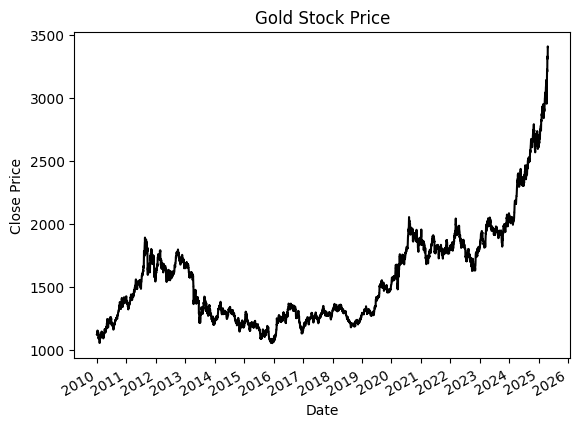

In [8]:
plt.plot(df_open['Date'], df_open['Close'], color='black')

locator = mdate.YearLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Gold Stock Price')
plt.show()

In [9]:
# Convertir la columna 'Date' a datetime si aún no lo es (debería serlo)
df_open['Date'] = pd.to_datetime(df_open['Date'])

# Filtrar el DataFrame desde el inicio de 2020 hasta el final de junio de 2024
train_df = df_open[(df_open['Date'] >= '2020-01-01') & (df_open['Date'] <= '2024-06-30')].copy()

train_df.tail()

Price,Date,Close,Close_Inflation,Close_Bonos,Close_dxy,Ratio_Oro_Dolar,Retorno_Oro,Volatilidad_Oro,RSI_Oro
5287,2024-06-26,2299.199951,105.050812,4.316,4.316,532.715468,-0.751107,0.996761,41.204596
5288,2024-06-27,2324.500000,105.247322,4.288,4.288,542.094203,1.100385,0.825225,56.114745
5289,2024-06-28,2327.699951,104.923058,4.343,4.343,535.965919,0.137662,0.825405,48.916244
5290,2024-06-29,2327.699951,104.923058,4.343,4.343,535.965919,0.000000,0.825405,48.916244
5291,2024-06-30,2327.699951,104.923058,4.343,4.343,535.965919,0.000000,0.825369,48.916244


In [10]:
# Asegurarse de que la columna 'Date' esté en formato datetime
df_open['Date'] = pd.to_datetime(df_open['Date'])

# Filtrar el DataFrame para obtener datos a partir del 1 de enero de 2024
test_df = df_open[df_open['Date'] >= '2024-07-01'].copy()

# Resetear el índice del DataFrame de prueba
test_df.reset_index(drop=True, inplace=True)

test_df.head() # Mostrar las primeras filas para verificar la fecha de inicio

Price,Date,Close,Close_Inflation,Close_Bonos,Close_dxy,Ratio_Oro_Dolar,Retorno_Oro,Volatilidad_Oro,RSI_Oro
0,2024-07-01,2327.600098,104.505707,4.479,4.479,519.669580,-0.004290,0.825354,55.006642
1,2024-07-02,2323.000000,104.703049,4.436,4.436,523.669988,-0.197633,0.777564,47.326632
2,2024-07-03,2359.800049,105.117432,4.355,4.355,541.859940,1.584161,0.771829,58.390432
3,2024-07-04,2359.800049,105.117432,4.355,4.355,541.859940,0.000000,0.716047,51.976281
4,2024-07-05,2388.500000,105.591026,4.272,4.272,559.105827,1.216203,0.760668,75.192190


In [11]:
# extract the Open values into a numpy array
X_train = train_df.iloc[:, 1:2].values

In [12]:
sc = MinMaxScaler(feature_range=(0, 1))

# fit the scaler only on X_train
sc.fit(X_train)

# scale X_train values to between 0 and 1
X_train_scaled = sc.transform(X_train)

In [13]:
train_data = []
train_labels = []

# create the training data using 60 timesteps
for i in range(TIMESTEP, len(X_train_scaled)):
  train_data.append(X_train_scaled[i-TIMESTEP:i, 0])
  train_labels.append(X_train_scaled[i, 0])

# convert train_data and train_labels back into numpy arrays
train_data, train_labels = np.array(train_data), np.array(train_labels)

# reshape train_data to be 3D so its compatible with the RNNs input requirements
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))

In [14]:
print(f"Training Data Shape: {train_data.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

Training Data Shape: (1583, 60, 1)
Training Labels Shape: (1583,)


In [15]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional # Import Bidirectional

regressor = Sequential()

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1))))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=60, return_sequences=True)))
regressor.add(Dropout(0.1))

regressor.add(Bidirectional(LSTM(units=80, return_sequences=True)))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units=120)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

c:\Users\Alumno_AI\Documents\Hugo\IAGen\ModeloOro\IAVenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
regressor.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min',patience=20)

In [18]:
history = regressor.fit(train_data, train_labels, epochs=50, batch_size=BATCH_SIZE, callbacks=[early_stopping], shuffle=False)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0103
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0185
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0123
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0025
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0085
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0112
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0121
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0072
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0035
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0026
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0033
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0026
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0027
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0030
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0017
Epo

In [19]:
regressor.save('modelo_oro.h5')

In [20]:
last_60_days_2023 = train_df.iloc[:, 1:2].tail(TIMESTEP)
last_60_days_2023 = pd.concat([last_60_days_2023, test_df.iloc[:, 1:2]])
last_60_days_2023 = sc.transform(last_60_days_2023)

X_test = []
for i in range(TIMESTEP, 79):
  X_test.append(last_60_days_2023[i-TIMESTEP:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

c:\Users\Alumno_AI\Documents\Hugo\IAGen\ModeloOro\IAVenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [21]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)
predicted_value

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


array([[2286.7007],
       [2288.672 ],
       [2288.5894],
       [2297.6404],
       [2306.99  ],
       [2322.169 ],
       [2335.0098],
       [2344.0474],
       [2340.9424],
       [2336.2944],
       [2334.866 ],
       [2345.8582],
       [2357.3445],
       [2366.5286],
       [2372.6255],
       [2378.143 ],
       [2392.4026],
       [2403.7197],
       [2411.1533]], dtype=float32)

Testing Data Shape: (236, 60, 1)
Testing Labels Shape: (236,)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Shape de predicted_value (original): (236, 1)
Shape de y_true (original): (236, 1)
Precisión Direccional en el conjunto de prueba: 36.60%
RMSE en el conjunto de prueba: 60.63
MAE en el conjunto de prueba: 44.59
R-cuadrado (R2) en el conjunto de prueba: 0.90
RMSE porcentual en el conjunto de prueba: 2.19%


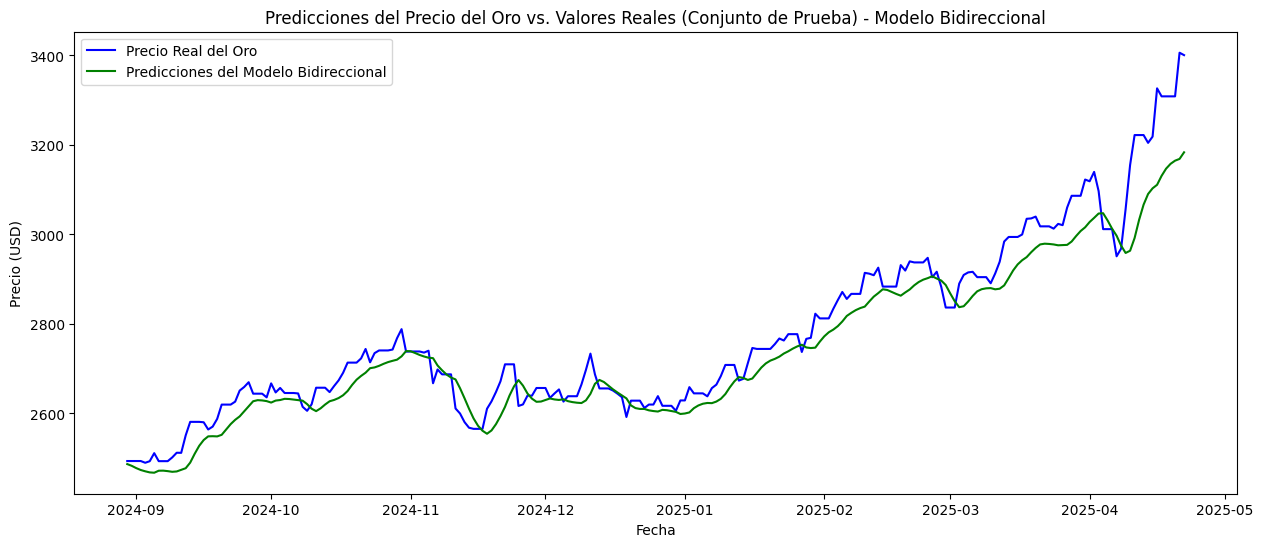

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Parámetros (ajusta según sea necesario)
TIMESTEP = 60
EPOCHS = 100
BATCH_SIZE = 32
HORIZON = 1 # Predicción del siguiente día

# 1. Preparación de los datos de prueba (similar al entrenamiento)
X_test = test_df.iloc[:, 1:2].values
X_test_scaled = sc.transform(X_test) # Usar el mismo scaler ajustado en los datos de entrenamiento

test_data = []
test_labels = []
for i in range(TIMESTEP, len(X_test_scaled)):
    test_data.append(X_test_scaled[i-TIMESTEP:i, 0])
    test_labels.append(X_test_scaled[i, 0])

test_data, test_labels = np.array(test_data), np.array(test_labels)
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))
print(f"Testing Data Shape: {test_data.shape}")
print(f"Testing Labels Shape: {test_labels.shape}")

# 2. Hacer predicciones en el conjunto de prueba
predicted_scaled = regressor.predict(test_data)

# 3. Invertir el escalado para obtener las predicciones en la escala original
predicted_value = sc.inverse_transform(predicted_scaled)
y_true = sc.inverse_transform(np.expand_dims(test_labels, axis=1))

print(f"Shape de predicted_value (original): {predicted_value.shape}")
print(f"Shape de y_true (original): {y_true.shape}")

# Calcular los cambios direccionales
def calculate_directional_accuracy(y_true, y_pred):
    # Calcular los cambios reales
    real_changes = np.sign(np.diff(y_true.flatten()))
    # Calcular los cambios predichos
    predicted_changes = np.sign(np.diff(y_pred.flatten()))
    # Eliminar el primer elemento para que las longitudes coincidan
    real_changes = real_changes[HORIZON-1:]
    predicted_changes = predicted_changes[:len(real_changes)]
    # Calcular la precisión direccional
    correct_directions = np.sum(real_changes == predicted_changes)
    total_directions = len(real_changes)
    if total_directions == 0:
        return 0.0
    return correct_directions / total_directions * 100

directional_accuracy = calculate_directional_accuracy(y_true, predicted_value)
print(f'Precisión Direccional en el conjunto de prueba: {directional_accuracy:.2f}%')

# 4. Calcular las métricas de magnitud
rmse = np.sqrt(mean_squared_error(y_true, predicted_value))
mae = mean_absolute_error(y_true, predicted_value)
r2 = r2_score(y_true, predicted_value)

print(f'RMSE en el conjunto de prueba: {rmse:.2f}')
print(f'MAE en el conjunto de prueba: {mae:.2f}')
print(f'R-cuadrado (R2) en el conjunto de prueba: {r2:.2f}')

# Cálculo del RMSE porcentual (respecto al precio promedio en el conjunto de prueba)
rmse_percent = (rmse / np.mean(y_true)) * 100
print(f'RMSE porcentual en el conjunto de prueba: {rmse_percent:.2f}%')

# 5. Visualización
plt.figure(figsize=(15, 6))
plt.plot(test_df['Date'][TIMESTEP:], y_true, color='blue', label='Precio Real del Oro')
plt.plot(test_df['Date'][TIMESTEP:], predicted_value, color='green', label='Predicciones del Modelo Bidireccional')
plt.title('Predicciones del Precio del Oro vs. Valores Reales (Conjunto de Prueba) - Modelo Bidireccional')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicciones Futuras (Próximo Año):
        Date   Prediction
0 2025-04-23  3197.685791
1 2025-04-24  3183.168213
2 2025-04-25  3160.169678
3 2025-04-26  3136.188965
4 2025-04-27  3112.601074


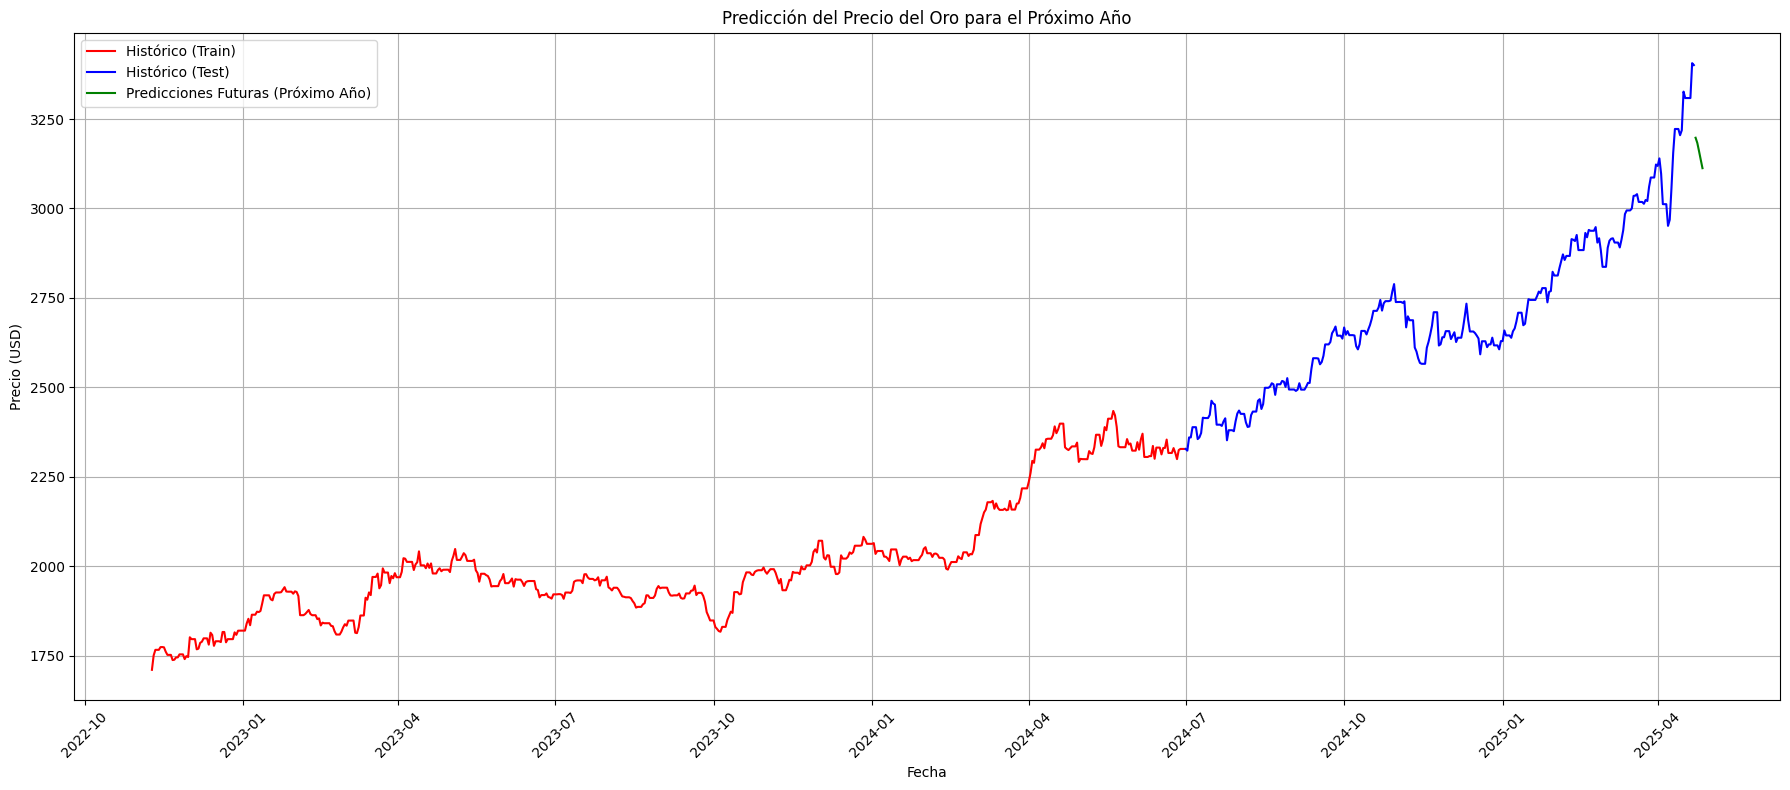

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Parámetros (ajusta según sea necesario)
TIMESTEP = 60
N_FUTURE_STEPS = 5  # Número de días futuros a predecir (aproximadamente un año)

# 1. Obtener los últimos TIMESTEP valores del conjunto de prueba (o entrenamiento si no hay suficiente prueba)
last_sequence = test_df.iloc[:, 1:2].tail(TIMESTEP).values
last_sequence_scaled = sc.transform(last_sequence)

# 2. Preparar la secuencia inicial para la predicción
future_predictions_scaled = []
current_sequence = last_sequence_scaled.reshape(1, TIMESTEP, 1)

# 3. Realizar las predicciones futuras
for i in range(N_FUTURE_STEPS):
    predicted_scaled = regressor.predict(current_sequence)
    future_predictions_scaled.append(predicted_scaled[0, 0])
    # Actualizar la secuencia para la siguiente predicción
    current_sequence = np.append(current_sequence[:, 1:, :], predicted_scaled.reshape(1, 1, 1), axis=1)

# 4. Invertir el escalado de las predicciones
future_predictions = sc.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# 5. Crear un DataFrame para las fechas futuras
last_date = pd.to_datetime(test_df['Date'].iloc[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N_FUTURE_STEPS, freq='D')
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Prediction': future_predictions.flatten()})

print("Predicciones Futuras (Próximo Año):")
print(future_predictions_df)

# 6. Visualizar las predicciones futuras junto con los datos históricos
plt.figure(figsize=(18, 8))  # Aumentar el tamaño de la figura para mejor visualización
plt.plot(train_df['Date'].tail(TIMESTEP * 10), train_df['Close'].tail(TIMESTEP * 10), color='red', label='Histórico (Train)')
plt.plot(test_df['Date'], test_df['Close'], color='blue', label='Histórico (Test)')
plt.plot(future_predictions_df['Date'], future_predictions_df['Prediction'], color='green', label='Predicciones Futuras (Próximo Año)')
plt.title('Predicción del Precio del Oro para el Próximo Año')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar etiquetas cortadas
plt.show()